NOTE: THIS NOTEBOOK IS FOR PREVIOUS VERSION OF RSEAP WHICH IS OBSOLETED. IT IS KEPT FOR REFERENCE PURPOSE.

## Example RuleFlow usage 01

A RuleFlow is a compute graph made up by RuleNode and DataNode. A RuleNode is a graph node accomodating a Rule.

RuleFlow is used in scenario where there is complex decisioning requiring chaining of multiple Rules.

Though not the most appropriate use case*, this notebook will demonstrate the construction of a decision tree using RuleFlow.

\* In a decision tree, the output of a RuleNode is always binary and a DataNode has exactly two child nodes, while RuleFlow is capable of handling more general scenarios.

We will be implementating the following decision tree:

<img src="images/decision_tree_01.png" width="600px"/>

In [1]:
import rseap

# define shorthands
c = rseap.Condition; v = rseap.ValueRange; o = rseap.Return;
Rule = rseap.Rule; RuleNode = rseap.RuleNode; DataNode = rseap.DataNode

### Create a Rule Flow

In [2]:
rule_flow = rseap.RuleFlow()

Define a binary output repeatedly used in a decision tree structure

In [3]:
binary_out = o.from_data({
    'inplace': True,        # <- use inplace to pass input as output to child node
    True  : {'_out': True}, # <- _out is a variable recording the decision of this node
    False : {'_out': False}
})

#### Create the input node

In [4]:
input_node = rseap.DataNode(name='input_data', ruleflow=rule_flow)

#### Create the first decision rule node

In [5]:
ruleNode01 = RuleNode(name='petal-length<2.45', rule=Rule(
  [c('petal_length', v({'ub': 2.45}))], binary_out,
))
ruleNode01 << input_node # airflow-syntax of adding parent/child node supported, otherwise
# ruleNode01.add_parent_node(input_node) <- this more verbose syntax also works
# input_node.add_child_node(ruleNode01)  <- this also works
# input_node >> ruleNode01               <- this also works
dataNode01 = DataNode(name='01')
dataNode01 << ruleNode01

#### Visualize the compute graph

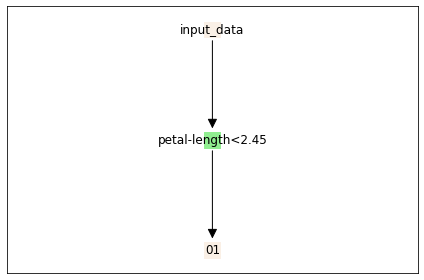

In [6]:
rule_flow.visualize()

#### Create other nodes and specify their lineage

In [7]:
DecisionNode01 = RuleNode(name='isSetosa', rule=Rule(
  [c('_out', v([True]))],
  o.from_data({'inplace': False, True: {'_out': 'Setosa'}})
))
DecisionNode01 << dataNode01
output_node_01 = DataNode(name='out_01')
output_node_01 << DecisionNode01

In [8]:
ruleNode02 = RuleNode(name='petal-width<1.75', rule=Rule(
  [c('petal_width', v({'ub': 1.75}))], 
    binary_out,
  [c('_out', v([False]))]
))
ruleNode02 << dataNode01
dataNode02 = DataNode(name='02')
dataNode02 << ruleNode02

In [9]:
ruleNode03 = RuleNode(name='petal-length<4.95', rule=Rule(
  [c('petal_length', v({'ub': 4.95}))], 
    binary_out,
  [c('_out', v([True]))]
))
ruleNode03 << dataNode02
dataNode03 = DataNode(name='03')
dataNode03 << ruleNode03

In [10]:
ruleNode04 = RuleNode(name='petal-length<4.85', rule=Rule(
  [c('petal_length', v({'ub': 4.85}))], 
    binary_out,
  [c('_out', v([False]))]
))
ruleNode04 << dataNode02
dataNode04 = DataNode(name='04')
dataNode04 << ruleNode04

In [11]:
ruleNode05 = RuleNode(name='isVersicolor', rule=Rule(
  [c('_out', v([True]))], 
  o.from_data({'inplace': False, True: {'_out': 'Versicolor'}})
))
ruleNode05 << dataNode03
output_node_02 = DataNode(name='out_02')
output_node_02 << ruleNode05

In [12]:
ruleNode05 = RuleNode(name='isVirginica1', rule=Rule(
  [c('_out', v([False]))],
  o.from_data({'inplace': False, True: {'_out': 'Virginica'}})
))
ruleNode05 << dataNode03
output_node_03 = DataNode(name='out_03')
output_node_03 << ruleNode05

In [13]:
ruleNode06 = RuleNode(name='isVirginica2', rule=Rule(
  [c('_out', v([True]))],
  o.from_data({'inplace': False, True: {'_out': 'Virginica'}})
))
ruleNode06 << dataNode04
output_node_04 = DataNode(name='out_04')
output_node_04 << ruleNode06

In [14]:
ruleNode07 = RuleNode(name='isVirginica3', rule=Rule(
  [c('_out', v([False]))],
  o.from_data({'inplace': False, True: {'_out': 'Virginica'}})
))
ruleNode07 << dataNode04
output_node_05 = DataNode(name='out_05')
output_node_05 << ruleNode07

Visualize the final tree

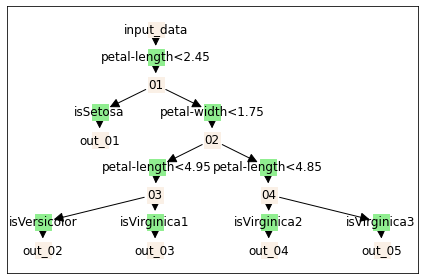

In [15]:
rule_flow.visualize()

#### Search node by name
by matching regular expression on the node name

In [16]:
rule_flow.search_nodes('petal.*1.75')

[['petal-width<1.75', <rseap.rule_flow.RuleNode at 0x7f77dcd61e80>]]

#### Run an inference over the RuleFlow

In [17]:
input_data = {'petal_length': 2.5, 'petal_width': 5}

In [18]:
result = rule_flow.apply(input_data)

The `result` is a dictonary object. Its `status` indicates whether the inference succeed or failed.

If successful, an `output` variable containing a list of dictionary of terminal nodes and their values will be available. Otherwise an `error` variable is returned.

The `record` is an RuleFlowRun object containing the statuses and logs of the inference run.

In [19]:
result

{'status': 'success',
 'output': [{'node': <rseap.rule_flow.DataNode at 0x7f77dcd7d7b8>,
   'value': {'_out': 'Virginica'}}],
 'record': <rseap.rule_flow.RuleFlowRun at 0x7f77dcca7f98>}

In [20]:
outputs = result['output']
for output in outputs:
    print(output['node'].name, ':', output['value'])

out_04 : {'_out': 'Virginica'}


In [21]:
record = result['record']

In [22]:
record.duration

0.0014879703521728516

The event logs can be printed out from the record

In [23]:
print(record.events_log.contents())

2021-01-21 00:05:19,062 - INFO - assigned input to root node: "input_data" [118e173b-9f80-4fb6-bde8-4122746c4ab1]
2021-01-21 00:05:19,062 - INFO - node executed: "input_data" [118e173b-9f80-4fb6-bde8-4122746c4ab1]
2021-01-21 00:05:19,062 - INFO - node ready for execution: "petal-length<2.45" [139e898b-2378-41df-9801-81ddb32d97d6]
2021-01-21 00:05:19,062 - INFO - aggregating parents data: {'118e173b-9f80-4fb6-bde8-4122746c4ab1': {'petal_length': 2.5, 'petal_width': 5}}
2021-01-21 00:05:19,062 - INFO - aggregated data: {'petal_length': 2.5, 'petal_width': 5}
2021-01-21 00:05:19,062 - INFO - computed data: {'petal_length': 2.5, 'petal_width': 5, '_out': False}
2021-01-21 00:05:19,062 - INFO - node executed: "petal-length<2.45" [139e898b-2378-41df-9801-81ddb32d97d6]
2021-01-21 00:05:19,062 - INFO - node ready for execution: "01" [e305f866-1e18-4d4a-a2d1-d066a8ef2e97]
2021-01-21 00:05:19,062 - INFO - aggregating parents data: {'139e898b-2378-41df-9801-81ddb32d97d6': {'petal_length': 2.5, 'p

### CRUD of ruleflow

In [24]:
# detect if rule already exists in rule engine => use old rule instead